In [9]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [23]:
# load data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

# Visualizaiton
PairGrid with violinplot is used for displaying the distribution of different variables between the two classes.  FacetGridis with barplot is used to display the mean of survivial for different group defined by cat, row and col.

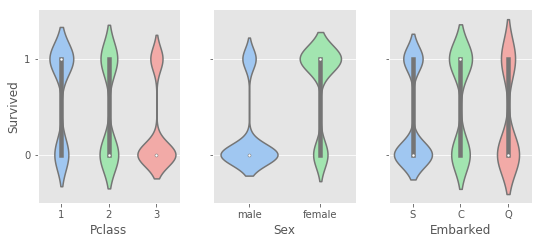

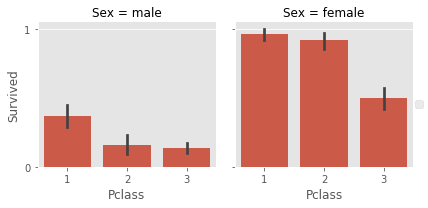

In [24]:
import seaborn as sns
g =sns.PairGrid(train,
                 x_vars=["Pclass", "Sex","Embarked"],
                 y_vars=["Survived"],
                 aspect=.75, size=3.5);
fig=g.map(sns.violinplot, palette="pastel")
g.axes[0,0].set_yticks([0,1])

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col)
    facet.map( sns.barplot , cat , target ) #barplot plot the target mean for each group
    facet.add_legend()
    return facet

g=plot_categories(train,cat='Pclass',target='Survived',col='Sex');
g.axes[0,0].set_yticks([0,1]);

# Feature Engineering
Below are the common features used by most Kagglers for titannic project. We leave the missing data as NaN, instead of imputing them with mean/median.... Xgboost will naturally handle missing data (quote from the inventor):

"Internally, XGBoost will automatically learn what is the best direction to go when a value is missing. Equivalently, this can be viewed as automatically "learn" what is the best imputation value for missing values based on reduction on training loss."

Tree-based models theoretically can handle missing data, but in sklearn 0.18.2, missing data need to be imputed before feeding them in model fitting.

In [25]:
def get_title(x):
    return x.split(',')[1].split('.')[0].strip()
def get_firstname_len(x):
    return len(x.split(',')[1].split('.')[1].strip())
def get_lastname_len(x):
    return len(x.split(',')[0].strip())

# fit the slicer on trainig set for categorizing continuous variables
k = 4
Fare_cuts = np.array([train['Fare'].quantile(i) for i in np.arange(0, 1, 1.0 / k)])
h = 4
Age_cuts = np.arange(train['Age'].min(), train['Age'].max(),
                     (train['Age'].max()-train['Age'].min()).astype(float)/h)
     
def categorize(x, slicer):
    res = np.empty(x.shape) * np.nan
    k = slicer.shape[0]
    res[x < slicer[1]] = 1
    res[x >= slicer[k - 1]] = k
    for i in range(2, k):
        res[(x >= slicer[i - 1]) & (x < slicer[i])] = i
    return res

train['Survived']= train['Survived'].astype(int)
      
full_data = [train, test]
for dataset in full_data:
    
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['firstname_len'] = dataset['Name'].apply(get_firstname_len)
    dataset['lastname_len'] = dataset['Name'].apply(get_lastname_len)

    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'].replace(to_replace=['Mlle', 'Ms', 'Mme'], value=['Miss', 'Miss', 'Mrs'], inplace=True)
    title_count = dataset.groupby('Title').size()
    dataset['Title'] = dataset['Title'].map(lambda x: 'others' if title_count[x] <= 1 else x)
    
    dataset['Cabin_type'] = dataset['Cabin'].apply(lambda x: '0' if type(x) == float else  x[0])

    ## Fare and Age can be categorized to reduce the tree complexity. 
    # dataset['Fare']=categorize(dataset['Fare'], Fare_cuts)
    # dataset['Age']=categorize(dataset['Age'], Age_cuts)

In [26]:
# fit the LabelEncoder on training set for categorical variables
# keep missing data as NaN 
from sklearn.preprocessing import LabelEncoder
catg_vars = ['Embarked', 'Cabin_type', 'Sex', 'Title']
coders = {}
for var_name in catg_vars:
    coders[var_name] = LabelEncoder().fit(train.loc[~train[var_name].isnull(), var_name])
    
for dataset in full_data:
    for var_name in catg_vars:
        dataset.loc[~dataset[var_name].isnull(), var_name] = \
            coders[var_name].transform(
                dataset.loc[~dataset[var_name].isnull(), var_name])
        
        # change the field with dtype=object(often because of the existence of Nan ) to appropriate type. 
        #  NaN can't be stored in an integer array. This is a known limitation of pandas at the moment; use float instead
        dataset[var_name]=dataset[var_name].astype(float)
        

# Feature selection
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'], axis = 1)
test  = test.drop(['Name', 'Ticket', 'Cabin', 'SibSp'], axis = 1)

In [27]:
# make sure the datatype appropriate for model training
# make dure no column with datatype = object due to missing data
train.head(2)
train.dtypes

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,FamilySize,firstname_len,lastname_len,Title,Cabin_type
0,0,3,1.0,22.0,0,7.2500,2.0,2,11,6,5.0,0.0
1,1,1,0.0,38.0,0,71.2833,0.0,2,37,7,6.0,3.0


Survived         int64  
Pclass           int64  
Sex              float64
Age              float64
Parch            int64  
Fare             float64
Embarked         float64
FamilySize       int64  
firstname_len    int64  
lastname_len     int64  
Title            float64
Cabin_type       float64
dtype: object

# Feature Statistics
plot the crosscorrelation of features and their distribution between two classes.

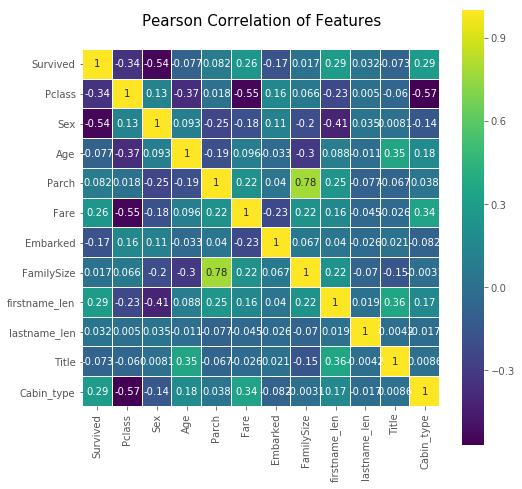

In [8]:
colormap = plt.cm.viridis
plt.figure(figsize=(8,8));
plt.title('Pearson Correlation of Features', y=1.05, size=15);
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

# Model Tuning 

max_depth, n_estimators, and learning_rate are the three most important parameters for XGBoost.Usudally, we need deeper trees and more estimators for continuous variables, because there aremuch more possible splits. Here in this case, if Age and Fare are categorized, we will need smaller values for max_depth and  n_estimators.

subsampling with increased n_estimators often can increase the accuracy.

In [18]:
# gridsearch, compute-intensive! 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


X=train.values[:,1:]
y=train['Survived'].values


gbm = xgb.XGBClassifier(objective='binary:logistic')

#  if Age and Fare are categorized into 4 bins, search around the following parameters 
# xgb_parameters_catg ={'max_depth':[3], 
#                         'n_estimators':[300],
#                         'learning_rate':[0.05]}
                        
xgb_parameters_cont = {'max_depth': [3,4],
                        'n_estimators':range(800,1001,100),
                        'learning_rate':np.arange(0.03,0.051,0.01),
                        'subsample':np.arange(0.7,1.01,0.1),
                        'colsample_bylevel':np.arange(0.7,1.01,0.1),
                        'reg_lambda':[2,3]}

gsearch = GridSearchCV(estimator = gbm,
                       param_grid = xgb_parameters_cont, 
                       scoring='accuracy',
                       n_jobs=4,iid=False, cv=5).fit(X, y)


print('The best performed model is :\n')
print gsearch.best_estimator_
print("\n Accuracy: %.2f%%" % (gsearch.best_score_ * 100.0))

The best performed model is :

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

 Accuracy: 83.84%


In [28]:
# Fit the model on the whole train set 

gbm = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9).fit(X,y)

predictions=gbm.predict(test.values[:,1:])

In [29]:
# generate prediction for the test set
# Kaggle needs the submission to have a certain format;
# see https://www.kaggle.com/c/titanic-gettingStarted/download/gendermodel.csv
# for an example of what it's supposed to look like.
submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                            'Survived': predictions })
submission.to_csv("submission.csv", index=False)

# Result
5-fold Crossvalidation score on train set is 83.4%. It may not appear impressive, but keep in mind I only used xgboost on a couple commonly used features.  stacking+xgboost will increase the performance.